# Personal Information
Name: **Ian van Beveren**

StudentID: **12867667**

Email: [**ian.van.beveren@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **21.03.2024**

## Current progress ##

Analysis done:
- Data format description and loading
- Metadata overview
- Speaker label per audio fragment distribution
- Speaker demographic overview
- Audio fragment duration distribution
- Audio signal visualtization

TODO:
- Audio data cleaning/repairing (if needed)
- Add Wyre (NFI) dataset to all analysis



# Data Context
This EDA consists of three open source datasets and two datasets belonging to the Netherlands Forensic Institute. \
Open source:
- A Dutch portion of the Commonlanguage dataset, crowdfunded speech data of different prompted sentences. Dutch
- The UCLA speaker variability dataset, each participant speaks after given a task from the one set of tasks. English
- The test set of the LibriSpeech dataset, a collection of different chapters from audiobooks. English

NFI:
- Frida telephone dataset, a collection of telephone conversations of one single speaker cut out. Dutch 
- Wyre dataset, four different tasks where different forensic scenario's are played out. English

All datasets consist of audio data featuring spoken language with speaker id labels. Further metadata differs for each dataset and will be explored further in the analysis.

# Data Description


In the EDA, three aspects of all datasets are analysed: generic metadata (if available), audio metadata and audio signal data. This data will be used to conduct validation experiments on machine learning models for speaker verifactions. With respect to this task, the biggest takeaways are as follows:
- Two datasets contain speaker demographic metadata. This can be helpful to conduct experiments on model fairness and bias
- The speaker to number of clips distribution is skewed for commonvoice and relatively even for the others. When making pairs as positive and negative examples for the ML models, this should be taken into account.
- The audio visualiztions show that data from the different datasets show different characteristics, like Frida being more noisy. This can provide good experiments that can show if a model iis able to generalize. 
- The audio clips differ a a lot between datasets, but not much within each dataset. This should be noted when combining datasets for experiments.

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import librosa
from IPython.display import Audio
from IPython.display import display


### Data Loading and table display

In [3]:
# Load your data here
# Commonvoice
meta = pd.read_csv('commonvoice-nl/commonvoice-nl/nl/validated.tsv', sep='\t')
durations = pd.read_csv('commonvoice-nl/commonvoice-nl/nl/clip_durations.tsv', sep='\t')

# UCLA
df_ucla = pd.read_excel("UCLA/public_database_speaker_info.xlsx")

# Librispeech
lv = sqlite3.connect('librispeech/lv-annotated.sqlite.db')

df_chapters = pd.read_sql_query("SELECT * FROM audio_chapters", lv)


meta

C:\Users\ivanb\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,0d709133bf209da7f0164653b6e5f9aee9d059ffaf7686...,common_voice_nl_17699535.mp3,De Aboriginals zijn de oorspronkelijke bewoner...,2,0,fifties,male,Nederlands Nederlands,NaN,nl,NaN
1,0dd5cf5dd5cf8efc5f78e3b124432fb2fda791f5fb935c...,common_voice_nl_30632766.mp3,Het gaat niet alleen over economisch rendement.,2,0,NaN,NaN,NaN,NaN,nl,NaN
2,0fca93407be6d482019f2463e60fbafdf598a82517e63c...,common_voice_nl_17694848.mp3,Mijn toetsenbord zit vol stof.,2,1,NaN,NaN,NaN,NaN,nl,NaN
3,175d4117110538cc68a8a0157a7f0a681f3e74fbe37e62...,common_voice_nl_18441136.mp3,Ze had de bank beschadigd met haar skateboard.,2,0,NaN,NaN,NaN,NaN,nl,NaN
4,1cc8cf1b0bd9932d12e44748c9ab33183484a04846a673...,common_voice_nl_32196042.mp3,Europa moet zich blijven concentreren op twee ...,2,0,NaN,NaN,NaN,NaN,nl,NaN
...,...,...,...,...,...,...,...,...,...,...,...
90090,f1d68c1db286092eb50d7d911841e6bf5d7bdb63128e3d...,common_voice_nl_27373769.mp3,Kijk eens naar de aanwezigen in deze vergaderz...,2,0,NaN,NaN,Nederlands Nederlands,NaN,nl,NaN
90091,f1d68c1db286092eb50d7d911841e6bf5d7bdb63128e3d...,common_voice_nl_27373770.mp3,Ten eerste de relatie met de kandidaat-landen.,2,0,NaN,NaN,Nederlands Nederlands,NaN,nl,NaN
90092,f1d68c1db286092eb50d7d911841e6bf5d7bdb63128e3d...,common_voice_nl_27373771.mp3,Degenen die eeuwenlang hun rijkdom hebben geba...,2,0,NaN,NaN,Nederlands Nederlands,NaN,nl,NaN
90093,f1d68c1db286092eb50d7d911841e6bf5d7bdb63128e3d...,common_voice_nl_27373772.mp3,Er is al te lang gewacht.,2,0,NaN,NaN,Nederlands Nederlands,NaN,nl,NaN


In [6]:
meta.columns

Index(['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age',
       'gender', 'accents', 'variant', 'locale', 'segment'],
      dtype='object')

Agraggate filepaths into dataframes for UCLA and Librispeech

In [4]:
main_folder_path = 'UCLA'

filenames = []
ids = []

# Traverse through the main folder
for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Iterate through files in the subfolder
        for filename in os.listdir(folder_path):
            # Check if the file has a .wav extension
            if filename.endswith('.wav'):
                # Extract the ID from the folder name
                folder_id = int(folder_name)  # Assuming the folder name is a number
                full_path = os.path.join(folder_path, filename)

                # Append data to lists
                ids.append(folder_id)
                filenames.append({'speakerID': folder_id, 'path': full_path})

# Create a DataFrame
df_paths = pd.DataFrame(filenames)

# Display the DataFrame
df_paths

merged_ucla = df_ucla.merge(df_paths, on="speakerID")
merged_ucla

,speakerID,sex,age,L1=English,L1=other,L2=EnglishL1,L2=EnglishAoA,Instructions_Session,Instructions_Clipping,Phonecall_Session,...,B_Vowels_Clipping,C_Vowels_Session,C_Vowels_Clipping,A_Time,B_Time,C_Time,A_RedoTime,B_RedoTime,C_RedoTime,path
0,1,F,22,N,NaN,Vietnamese,10,A,OK,C,...,OK,C,OK,12:17:34,13:40:59,12:27:26,NaN,12:33:02,NaN,UCLA\001\1A_instructions.wav
1,1,F,22,N,NaN,Vietnamese,10,A,OK,C,...,OK,C,OK,12:17:34,13:40:59,12:27:26,NaN,12:33:02,NaN,UCLA\001\1A_neutral.wav
2,1,F,22,N,NaN,Vietnamese,10,A,OK,C,...,OK,C,OK,12:17:34,13:40:59,12:27:26,NaN,12:33:02,NaN,UCLA\001\1A_sentences.wav
3,1,F,22,N,NaN,Vietnamese,10,A,OK,C,...,OK,C,OK,12:17:34,13:40:59,12:27:26,NaN,12:33:02,NaN,UCLA\001\1A_vowels.wav
4,1,F,22,N,NaN,Vietnamese,10,A,OK,C,...,OK,C,OK,12:17:34,13:40:59,12:27:26,NaN,12:33:02,NaN,UCLA\001\1B_happy.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,260,M,22,N,NaN,Mandarin,not_available,A,OK,B,...,OK,C,OK,13:41:00,14:02:00,11:35:00,NaN,NaN,NaN,UCLA\260\260B_vowels.wav
2084,260,M,22,N,NaN,Mandarin,not_available,A,OK,B,...,OK,C,OK,13:41:00,14:02:00,11:35:00,NaN,NaN,NaN,UCLA\260\260C_annoyed.wav
2085,260,M,22,N,NaN,Mandarin,not_available,A,OK,B,...,OK,C,OK,13:41:00,14:02:00,11:35:00,NaN,NaN,NaN,UCLA\260\260C_sentences.wav
2086,260,M,22,N,NaN,Mandarin,not_available,A,OK,B,...,OK,C,OK,13:41:00,14:02:00,11:35:00,NaN,NaN,NaN,UCLA\260\260C_video.wav


In [8]:
merged_ucla.columns

Index(['speakerID', 'sex', 'age', 'L1=English', 'L1=other', 'L2=EnglishL1',
       'L2=EnglishAoA', 'Instructions_Session', 'Instructions_Clipping',
       'Phonecall_Session', 'Phonecall_Clipping', 'PromptsN_Session',
       'PromptsN_Clipping', 'PromptsN_Conversation', 'PromptsN_Rating',
       'PromptsH_Session', 'PromptsH_Clipping', 'PromptsH_Conversation',
       'PromptsH_Rating', 'PromptsA_Session', 'PromptsA_Clipping',
       'PromptsA_Conversation', 'PromptsA_Rating', 'A_Sentences_Session',
       'A_Sentences_Clipping', 'B_Sentences_Session', 'B_Sentences_Clipping',
       'C_Sentences_Session', 'C_Sentences_Clipping', 'Video_Session',
       'Video_Clipping', 'Video_Rating', 'A_Vowels_Session',
       'A_Vowels_Clipping', 'B_Vowels_Session', 'B_Vowels_Clipping',
       'C_Vowels_Session', 'C_Vowels_Clipping', 'A_Time', 'B_Time', 'C_Time',
       'A_RedoTime', 'B_RedoTime', 'C_RedoTime', 'path'],
      dtype='object')

In [10]:
root_directory = 'librispeech/LibriSpeech/test-clean'

filenames = []
chapter_ids = []
book_ids = []

# Traverse through the main folder
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file.endswith('.flac'):
            # Append the filename and folder name to the lists
            chapter_ids.append(int(os.path.basename(root)))
            book_id = os.path.basename(os.path.dirname(root))
            book_ids.append(int(book_id))
            filenames.append(book_id + "/" + os.path.basename(root) + "/" + file)


# Create a DataFrame
data = {'path': filenames, 'id': chapter_ids, 'bookID': book_ids}
paths_libri = pd.DataFrame(data)
df_libri = paths_libri.merge(df_chapters, on='id')
df_libri


,path,id,bookID,project_id,title,chapter_number,time_seconds,audio_url,reader_id,ia_64kbps_id,ia_128kbps_id,url_64kbps,url_128kbps,seconds_64kbps,seconds_128kbps
0,1089/134686/1089-134686-0000.flac,134686,1089,890,Ch3 Pt1,7,1002,http://www.archive.org/download/portrait_artis...,1089,25275.0,25274,https://archive.org/download/portrait_artist_p...,https://archive.org/download/portrait_artist_p...,1002.0,1002
1,1089/134686/1089-134686-0001.flac,134686,1089,890,Ch3 Pt1,7,1002,http://www.archive.org/download/portrait_artis...,1089,25275.0,25274,https://archive.org/download/portrait_artist_p...,https://archive.org/download/portrait_artist_p...,1002.0,1002
2,1089/134686/1089-134686-0002.flac,134686,1089,890,Ch3 Pt1,7,1002,http://www.archive.org/download/portrait_artis...,1089,25275.0,25274,https://archive.org/download/portrait_artist_p...,https://archive.org/download/portrait_artist_p...,1002.0,1002
3,1089/134686/1089-134686-0003.flac,134686,1089,890,Ch3 Pt1,7,1002,http://www.archive.org/download/portrait_artis...,1089,25275.0,25274,https://archive.org/download/portrait_artist_p...,https://archive.org/download/portrait_artist_p...,1002.0,1002
4,1089/134686/1089-134686-0004.flac,134686,1089,890,Ch3 Pt1,7,1002,http://www.archive.org/download/portrait_artis...,1089,25275.0,25274,https://archive.org/download/portrait_artist_p...,https://archive.org/download/portrait_artist_p...,1002.0,1002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2615,908/31957/908-31957-0021.flac,31957,908,4199,4 - Chapters 31-44,4,832,http://www.archive.org/download/sonnetsfrompor...,908,131121.0,131120,https://archive.org/download/sonnetsfromportug...,https://archive.org/download/sonnetsfromportug...,832.0,832
2616,908/31957/908-31957-0022.flac,31957,908,4199,4 - Chapters 31-44,4,832,http://www.archive.org/download/sonnetsfrompor...,908,131121.0,131120,https://archive.org/download/sonnetsfromportug...,https://archive.org/download/sonnetsfromportug...,832.0,832
2617,908/31957/908-31957-0023.flac,31957,908,4199,4 - Chapters 31-44,4,832,http://www.archive.org/download/sonnetsfrompor...,908,131121.0,131120,https://archive.org/download/sonnetsfromportug...,https://archive.org/download/sonnetsfromportug...,832.0,832
2618,908/31957/908-31957-0024.flac,31957,908,4199,4 - Chapters 31-44,4,832,http://www.archive.org/download/sonnetsfrompor...,908,131121.0,131120,https://archive.org/download/sonnetsfromportug...,https://archive.org/download/sonnetsfromportug...,832.0,832


In [11]:
df_libri.columns

Index(['path', 'id', 'bookID', 'project_id', 'title', 'chapter_number',
       'time_seconds', 'audio_url', 'reader_id', 'ia_64kbps_id',
       'ia_128kbps_id', 'url_64kbps', 'url_128kbps', 'seconds_64kbps',
       'seconds_128kbps'],
      dtype='object')

In [8]:
folder_path = 'FRIDA telephone'

# List all files in the folder
files = os.listdir(folder_path)

# Filter files that start with 'SP'
audio_files = [file for file in files if file.startswith('SP')]

# Extract ids from filenames
ids = [int(file.split('SP')[1].split('_')[0].split('-')[0]) for file in audio_files]

# Create dataframe
frida = pd.DataFrame({'filepath': [os.path.join(folder_path, file) for file in audio_files],
                   'Speaker id': ids})
frida

,filepath,Speaker id
0,FRIDA telephone\SP003-2-6-2_edit.wav,3
1,FRIDA telephone\SP003-2-8-2_edit.wav,3
2,FRIDA telephone\SP004-2-2-5_edit.wav,4
3,FRIDA telephone\SP004-2-4-5_edit.wav,4
4,FRIDA telephone\SP004-2-6-2_edit.wav,4
...,...,...
1415,FRIDA telephone\SP266-1-6-2_edit.wav,266
1416,FRIDA telephone\SP266-1-8-2_edit.wav,266
1417,FRIDA telephone\SP266-2-2-5_edit.wav,266
1418,FRIDA telephone\SP266-2-4-5_edit.wav,266


### Dataset file structure ###

The commonvoice dataset has all files in collected in a single folder. Structuring is done in tsv files. For this EDA, only the validated.tsv (loaded as 'meta' as a dataframe) will be used, so only a subset of the audio files in the folder are considered. 

The files are submitted by volunteers online, the validated clips are validated on correct replication of the given speech task.

For the UCLA dataset, each speaker spoke in 3 sessions A, B and C, and in each sessions were given the same tasks:
- instructions in session A
- neutral in session A

- happy in session B
- phonecall in session B

- annoyed in session C
- video in session C

Each participant's recordings are in a seperate folder containing all session audio files.


The librispeech dataset is collected in one folder representing a book chapter and then another folder representing a chapter. The metadata is collected in sqlite databases. From the chapters table, all audio files and their speaker id's can be extracted. Further metadata can be found in the books and readers tables.

The Frida dataset has no metadata, it just consists of one folder containing the audio files and with speaker id's noted in the filename

### Audio cleaning and missing data ###
TODO

### Number of audio fragments per speaker: 
We show the distribution of the amount of audio clips for each speaker for every dataset

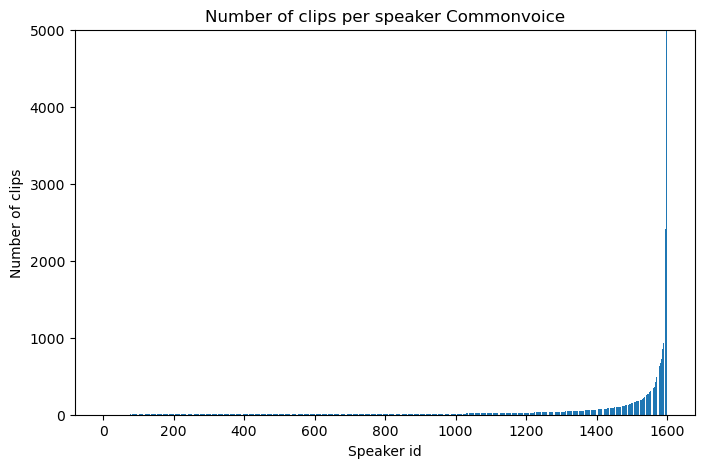

In [22]:
meta['id_factorized'] = pd.factorize(meta['client_id'])[0]
counts = meta["id_factorized"].value_counts(sort=False)
plt.figure(figsize=(8, 5))
plt.ylim((0, 5000))   # set the ylim to bottom, top
plt.bar(counts.index, counts.values)
plt.title("Number of clips per speaker Commonvoice")
plt.xlabel("Speaker id")
plt.ylabel("Number of clips")
plt.show()


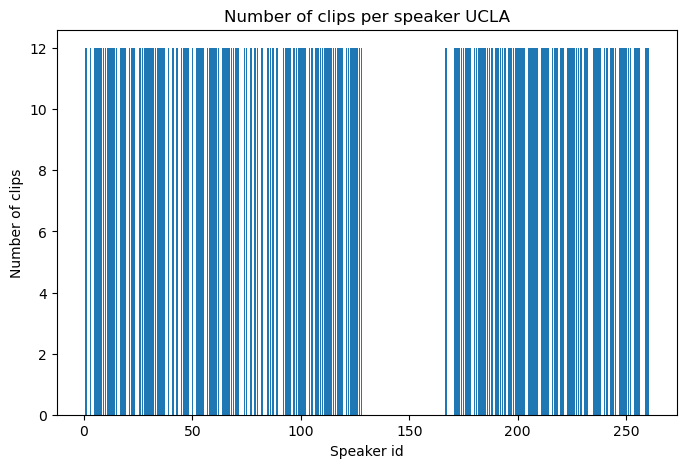

Int64Index([  1,   3,   5,   6,   7,   8,   9,  10,  11,  12,
            ...
            248, 249, 250, 251, 252, 254, 255, 256, 259, 260],
           dtype='int64', length=174)

In [23]:
plt.figure(figsize=(8, 5))
counts = df_paths["speakerID"].value_counts(sort=False)
plt.bar(counts.index, counts.values)
plt.title("Number of clips per speaker UCLA")
plt.xlabel("Speaker id")
plt.ylabel("Number of clips")
plt.show()
counts.index


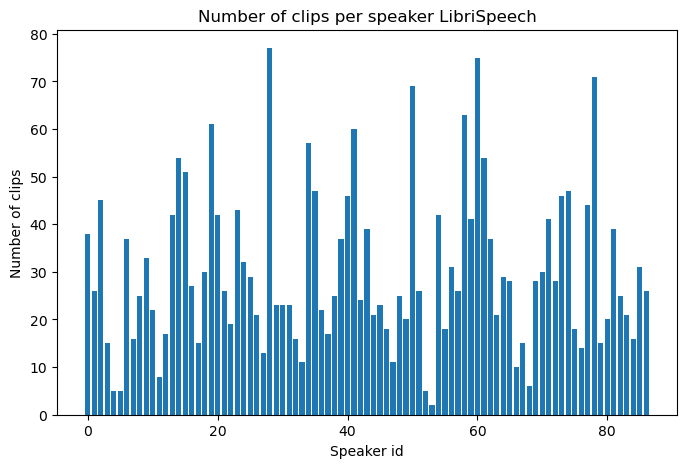

In [24]:

df_libri['id_factorized'] = pd.factorize(df_libri['id'])[0]

counts = df_libri["id_factorized"].value_counts(sort=True)
plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts.values)
plt.title("Number of clips per speaker LibriSpeech")
plt.xlabel("Speaker id")
plt.ylabel("Number of clips")
plt.show()


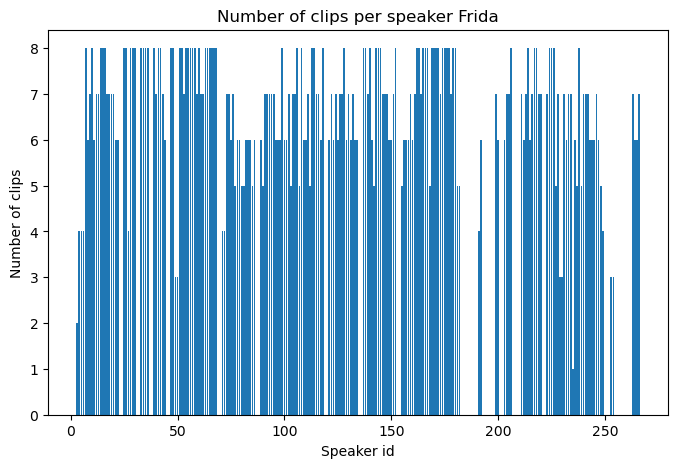

In [25]:
counts = frida["Speaker id"].value_counts(sort=True)
plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts.values)
plt.title("Number of clips per speaker Frida")
plt.xlabel("Speaker id")
plt.ylabel("Number of clips")
plt.show()


From these barcharts we can see both missing speaker id's and if there is an important skew in the distribution of clips per speaker. Two things are very noticable: The commonlanguage dataset is very skewed, with a small number of speakers having a large amount of contributed clips. Also there is a big chunk of speakers missing in the UCLA dataset.

### Audio clip durations:
Histograms of all audio clip durations for all datasets

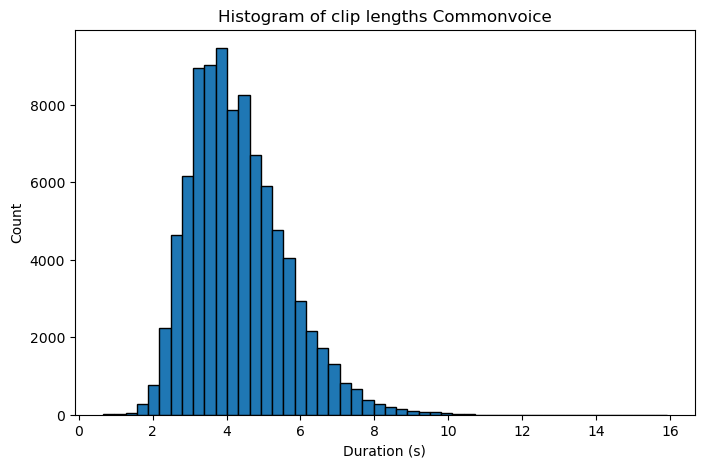

avg length: 4.319867428825114


In [27]:
# ...
plt.figure(figsize=(8, 5))
length = durations[durations['clip'].isin(meta['path'])]["duration[ms]"]
plt.title("Histogram of clip lengths Commonvoice")
plt.xlabel("Duration (s)")
plt.ylabel('Count')
plt.hist(length / 1000, bins=50, edgecolor='black')
plt.show()
print("avg length: " + str(np.mean(length / 1000)))

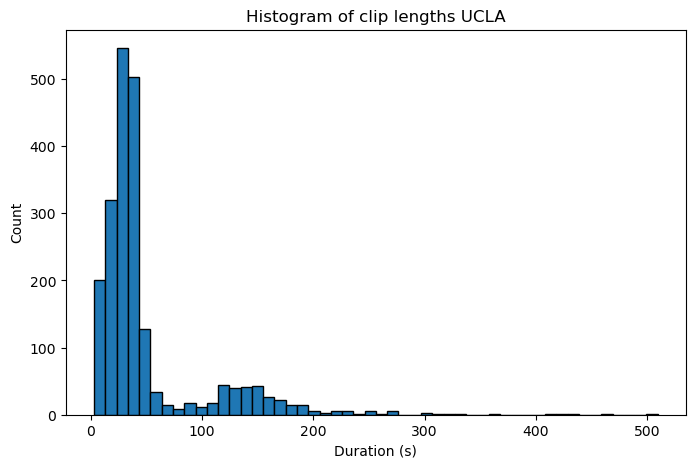

avg length: 50.03579232587032


In [28]:
file_durations = []

for path in df_paths["path"].tolist():
    y, sr = librosa.load(path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    file_durations.append(duration)

# file_durations

plt.figure(figsize=(8, 5))
plt.title("Histogram of clip lengths UCLA")
plt.xlabel("Duration (s)")
plt.ylabel('Count')
plt.hist(file_durations, bins=50, edgecolor='black')
plt.show()
print("avg length: " + str(np.mean(file_durations)))


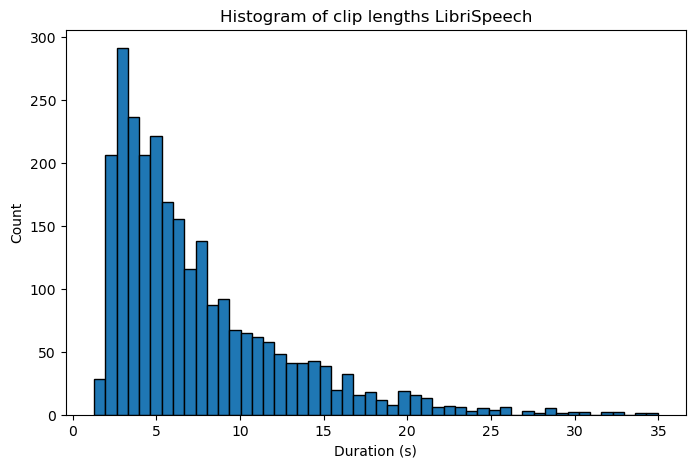

avg length: 7.4246109255725194


In [29]:
file_durations = []

for path in df_libri["path"].tolist():
    y, sr = librosa.load("librispeech/LibriSpeech/test-clean/" + path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    file_durations.append(duration)

plt.figure(figsize=(8, 5))
plt.title("Histogram of clip lengths LibriSpeech")
plt.xlabel("Duration (s)")
plt.ylabel('Count')
plt.hist(file_durations, bins=50, edgecolor='black')
plt.show()
print("avg length: " + str(np.mean(file_durations)))


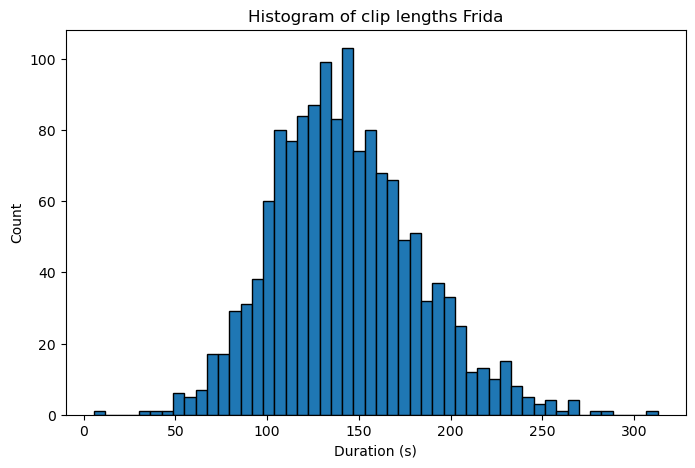

avg length: 142.5382650528169


In [30]:
file_durations = []

for path in frida["filepath"].tolist():
    y, sr = librosa.load(path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    file_durations.append(duration)

plt.figure(figsize=(8, 5))
plt.title("Histogram of clip lengths Frida")
plt.xlabel("Duration (s)")
plt.ylabel('Count')
plt.hist(file_durations, bins=50, edgecolor='black')
plt.show()
print("avg length: " + str(np.mean(file_durations)))


These figures show the duration distribution of the different audio files. Frida has the longest clips, while commonlanguage the shortest overall.

### Speaker demographics
The commonvoice and UCLA datasets also contain data about speaker participant demographics. Commonvoice has participant gender and age. UCLA has speaker age and second languages

In [54]:
age_props = meta["age"].value_counts(normalize=True)
gender_props = meta["gender"].value_counts(normalize=True)

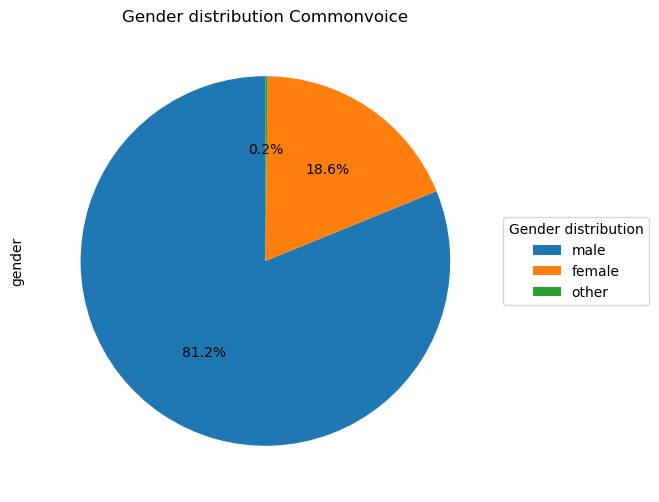

In [34]:
plt.figure(figsize=(10, 6))
ax = gender_props.plot.pie(autopct='%1.1f%%', startangle=90, labels=None)
ax.legend(gender_props.index, title='Gender distribution', bbox_to_anchor=(1, 0.5), loc="center left")
plt.title("Gender distribution Commonvoice")
plt.show()

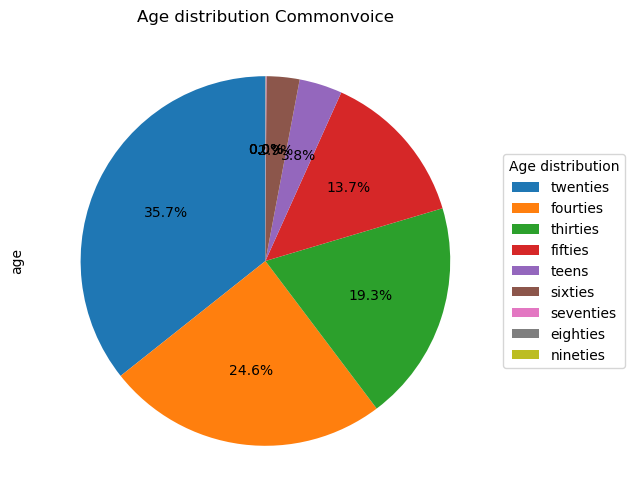

In [35]:
plt.figure(figsize=(10, 6))
ax = age_props.plot.pie(autopct='%1.1f%%', startangle=90, labels=None)
ax.legend(age_props.index, title='Age distribution', bbox_to_anchor=(1, 0.5), loc="center left")
plt.title("Age distribution Commonvoice")
plt.show()

UCLA contains speaker's second languages and whether they speak English natively

In [36]:

nonnative = df_ucla.loc[df_ucla['L1=English'] == "N"]
print("Percentage of nonnative English speakers: " + str((len(nonnative) / len(df_ucla) * 100)))

Percentage of nonnative English speakers: 26.732673267326735


Pie charts showing l1 (native)  non English spoken languages and l2 (second language) non English spoken languages

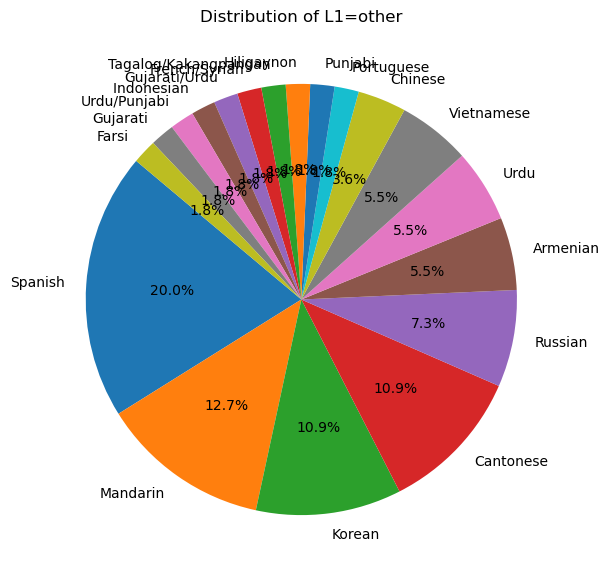

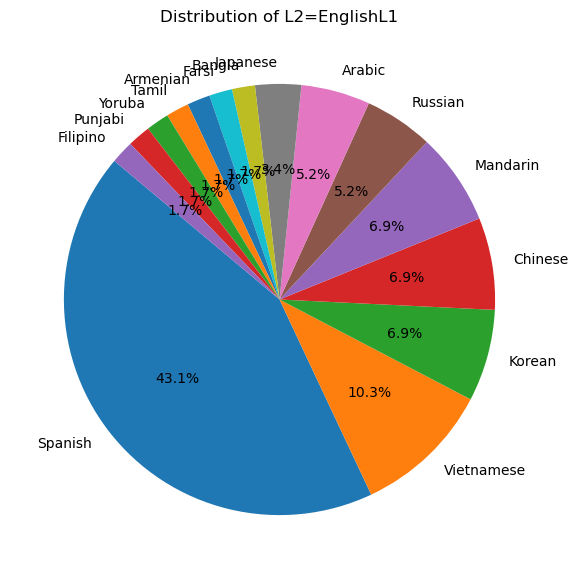

In [41]:
selected_columns = ['L1=other', 'L2=EnglishL1']

# Loop through selected columns
for selected_column in selected_columns:
    # Get the value counts
    value_counts = df_ucla[selected_column].value_counts()

    # Plot the pie chart
    plt.figure(figsize=(7, 7))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of {selected_column}')
    plt.show()

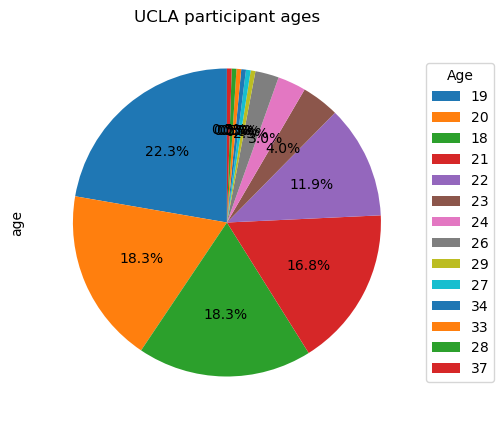

In [42]:
plt.figure(figsize=(5, 5))
plt.title("UCLA participant ages")
age_props = df_ucla["age"].value_counts(normalize=True)
ax = age_props.plot.pie(autopct='%1.1f%%', startangle=90, labels=None)
ax.legend(age_props.index, title='Age', bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()

### Audio signal visualizations ###
Some samples are taken of each dataset and their waveforms, mel-spectograms and MFCC's are shown. These are audio features that are often extracted before being put into machine learning models as pre-processing. 

Mel-spectograms are the signals in frequency domain and put on the mel scale, which brings out features that the human sensory system would perceive.

Computation of MFCC's is a further processing step of a mel-spectogram. This captures the shape of the power spectrum of the signal and is also useful for machine learning applications.

In [43]:
common_sample = meta.sample(1)["path"].to_string(index=False)
ucla_sample = merged_ucla.sample(1)["path"].to_string(index=False)
libri_sample = df_libri.sample(1)["path"].to_string(index=False)
frida_sample = frida.sample(1)["filepath"].to_string(index=False)

samples = ["commonvoice-nl/commonvoice-nl/nl/clips/" + common_sample, ucla_sample, "librispeech/LibriSpeech/test-clean/" + libri_sample, frida_sample]
# Audio(samples[0])
samples

['commonvoice-nl/commonvoice-nl/nl/clips/common_voice_nl_37984454.mp3',
 'UCLA\\085\\85C_sentences.wav',
 'librispeech/LibriSpeech/test-clean/2830/3979/2830-3979-0002.flac',
 'FRIDA telephone\\SP020-2-2-5_edit.wav']

Total number of samples in the recording: 115101
Sampling rate of the recording: 22050
Total number of samples in the recording: 678407
Sampling rate of the recording: 22050
Total number of samples in the recording: 95146
Sampling rate of the recording: 22050
Total number of samples in the recording: 2402348
Sampling rate of the recording: 22050


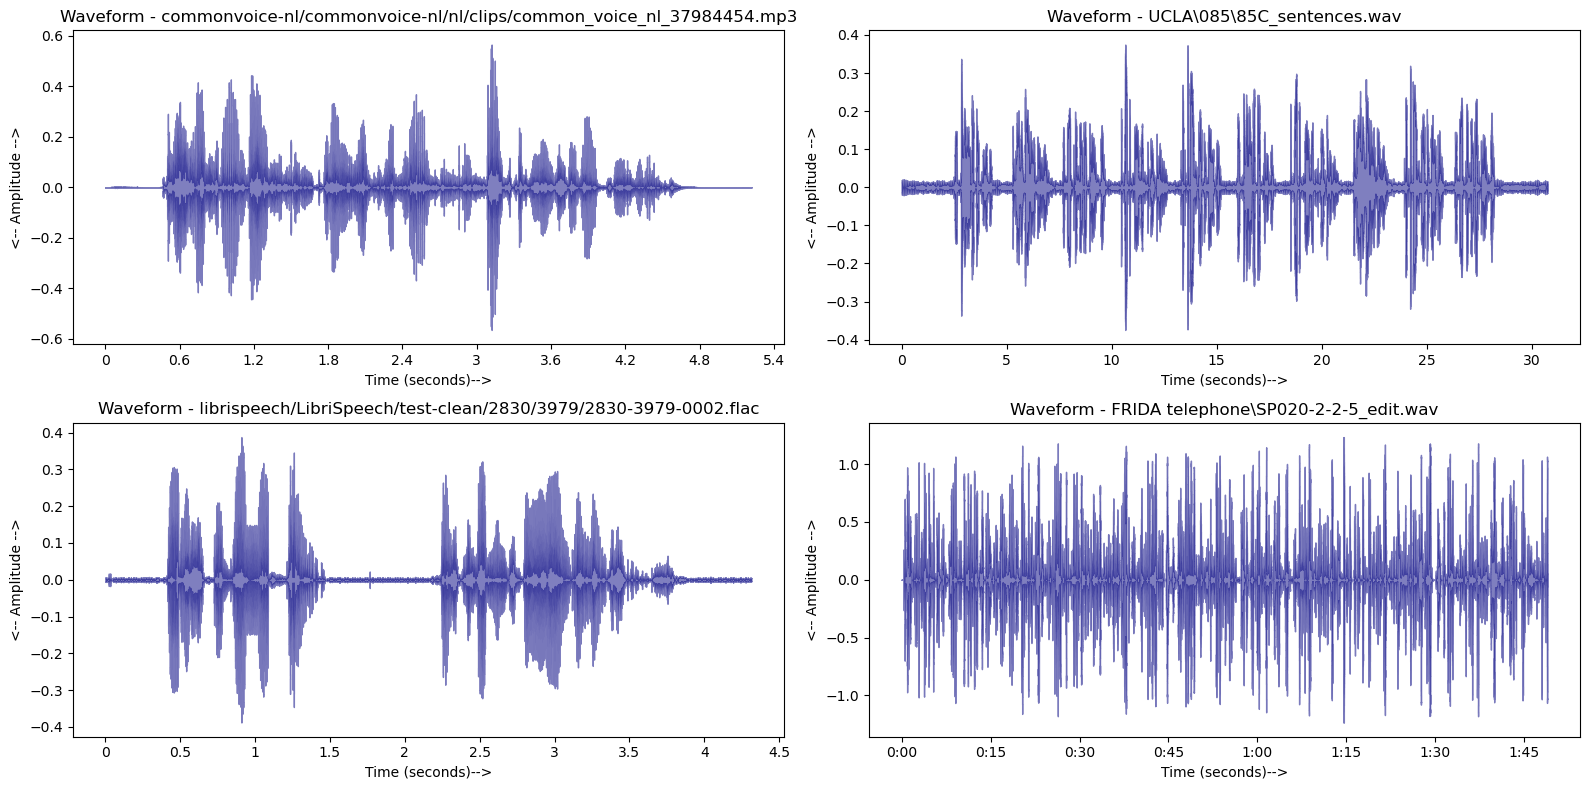

In [44]:
def plot_waveform(samples, df):
    plot_count = 0
    plt.figure(figsize=(16, 8))

    for sample in samples:
        amp, sr = librosa.load(sample)
        print(f'Total number of samples in the recording: {len(amp)}')
        print(f'Sampling rate of the recording: {sr}')

#         record_df = df[df["path"] == sample]
#         display(record_df)

        plot_count += 1

        plt.subplot(2, 2, plot_count)
        plt.title(f'Waveform - {sample}')

        # Plot the recording waveform
        librosa.display.waveshow(y=amp, sr=sr, color='navy', alpha=0.5)
        plt.xlabel('Time (seconds)-->')
        plt.ylabel('<-- Amplitude -->')

    plt.tight_layout()
    plt.show()
plot_waveform(samples, meta)


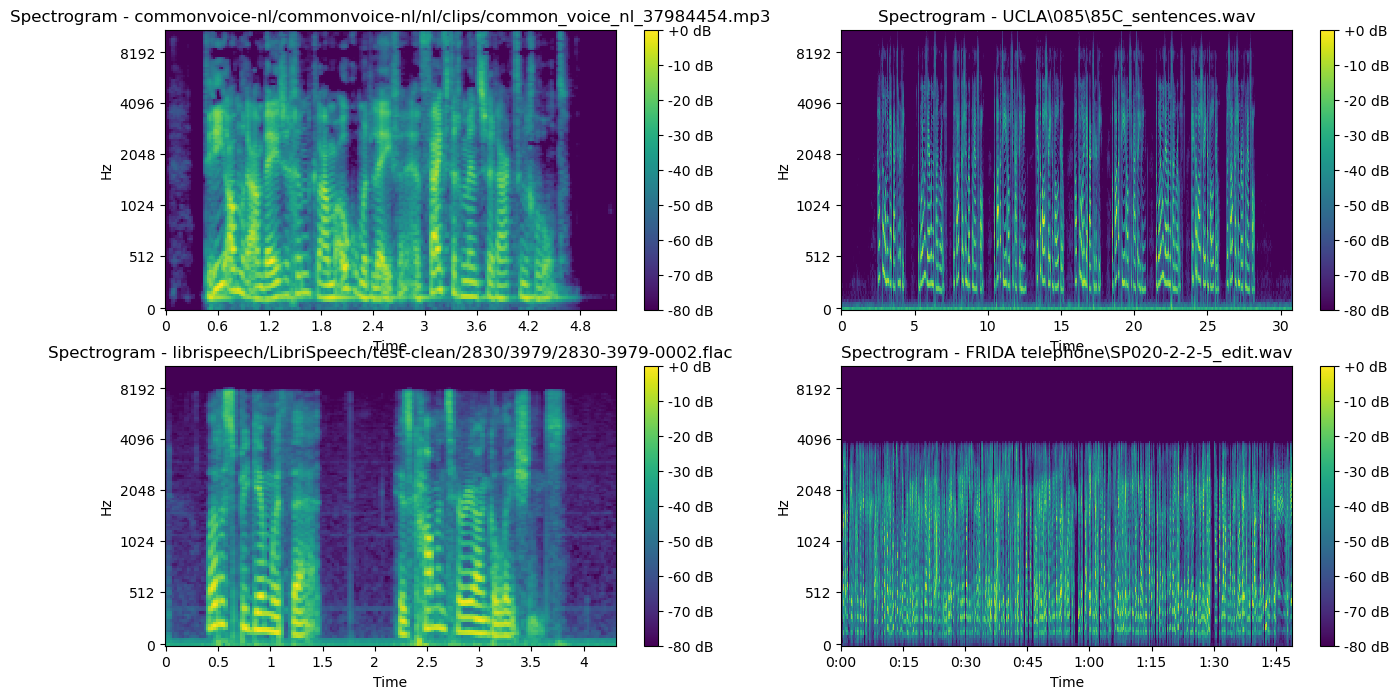

In [45]:
plot_count = 0
plt.figure(figsize=(16, 8))

for sample in samples:
    amp, sr = librosa.load(sample)

    spec = librosa.feature.melspectrogram(y=amp, sr=sr)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    
    # Increment the plot counter
    plot_count += 1

    # Set up the subplot
    plt.subplot(2, 2, plot_count)
    plt.title(f'Spectrogram - {sample}')

    # Plot the spectrogram
    librosa.display.specshow(spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    
    
plt.show()

(225,)
(1326,)
(186,)
(4693,)


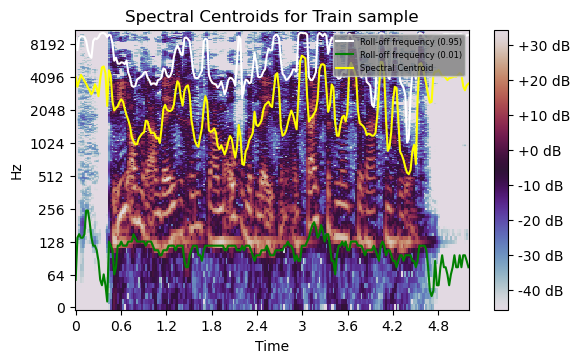

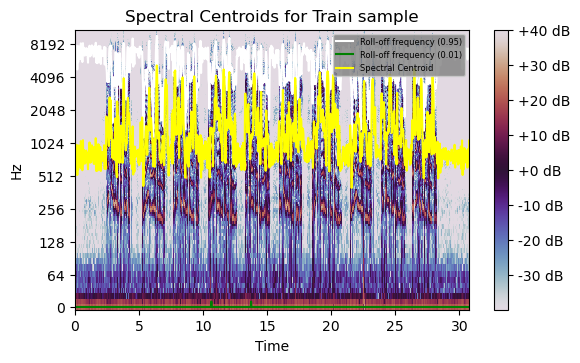

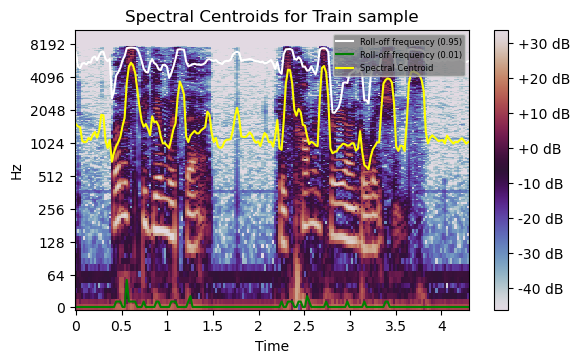

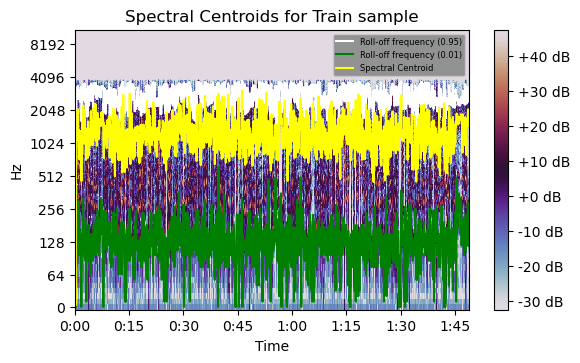

In [47]:
plot_count = 0
for sample in samples:
    amp, sr = librosa.load(sample)
    spec = librosa.stft(amp)
    # convert amplitude into decibel scale
    db = librosa.amplitude_to_db(abs(spec))
    spectral_centroids = librosa.feature.spectral_centroid(y=amp, sr=sr)[0]
    print(spectral_centroids.shape)

    # extract the time and frame indices
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    
    spectral_rolloff_full = librosa.feature.spectral_rolloff(y=amp, sr=sr,
                                                         roll_percent=0.95)[0]
    spectral_rolloff_empty = librosa.feature.spectral_rolloff(y=amp, sr=sr, 
                                                          roll_percent=0.01)[0]

    
    plot_count += 1
    # Set up the subplot
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, plot_count)
    plt.title("Spectral Centroids for Train sample")

    librosa.display.specshow(db, sr=sr, x_axis='time', 
                             y_axis='log', cmap='twilight')
    librosa.display.specshow(db, sr=sr, x_axis='time', 
                         y_axis='log', cmap='twilight')
    plt.plot(t, spectral_rolloff_full, color='white', 
         label='Roll-off frequency (0.95)')
    plt.plot(t, spectral_rolloff_empty, color='green', 
         label='Roll-off frequency (0.01)')


    plt.plot(t, spectral_centroids, color='yellow', 
             label='Spectral Centroid')
    plt.colorbar(format='%+2.0f dB')
    plt.legend(loc='upper right', fontsize=6, facecolor='gray')
plt.show()


(80, 225)


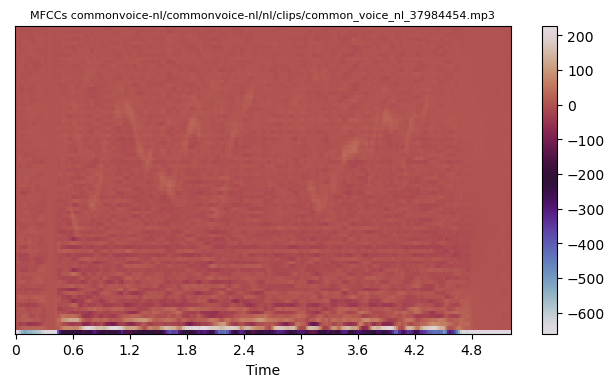

(80, 1326)


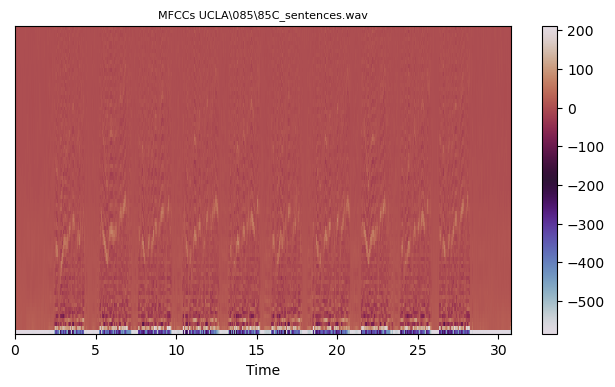

(80, 186)


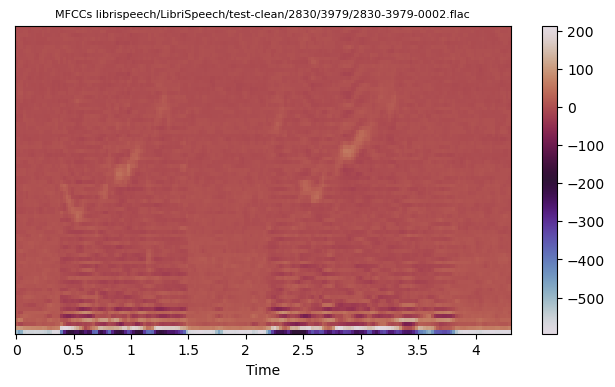

(80, 4693)


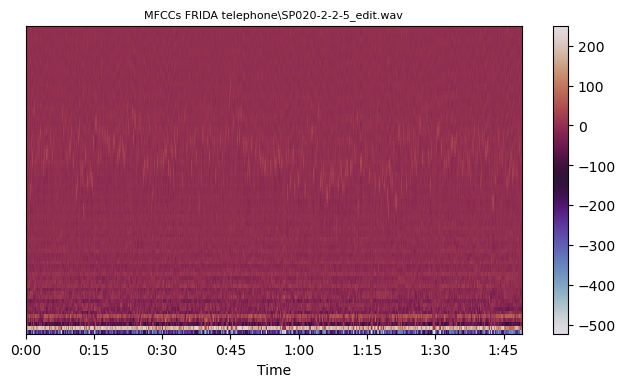

In [53]:
for sample in samples:
    amp, sr = librosa.load(sample)
    spec = librosa.stft(amp)

    mfccs = librosa.feature.mfcc(y=amp, sr=sr, n_mfcc=80)
    print(mfccs.shape)

    # display the scaled mfccs
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', 
                             cmap='twilight')
    plt.title('MFCCs ' + str(sample), fontsize=8)
    plt.colorbar()
    plt.show()
